In [ ]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LogisticRegression
from keras.models import Sequential
from keras.layers import Dense, LeakyReLU, BatchNormalization
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
from keras import initializers
# Compile the GAN
from keras.models import Model
from keras.layers import Input

In [ ]:
df=pd.read_excel("gold_futures.xlsx")

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])

df.fillna(method='ffill', inplace=True)

df['Price_Change'] = df['Close'] - df['Open']  # Price change in a day
df['Price_Movement'] = np.where(df['Price_Change'] > 0, 1, 0)  # Label: Up=1, Down=0
df['Volatility'] = df['High'] - df['Low']  # Volatility of the day
df['Moving_Avg'] = df['Close'].rolling(window=5).mean()  # 5-Day Moving Average

df.dropna(inplace=True)

X = df[['Open', 'High', 'Low', 'Close', 'Volume', 'Volatility', 'Moving_Avg']]
y = df['Price_Movement']


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

C:\Users\FAST LAPTOP\AppData\Local\Temp\ipykernel_20672\2774020657.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


# Implementing the GAN for Data Augmentation



In [ ]:
# Define the GAN Generator model
def build_generator(input_dim):
    model = Sequential()
    model.add(Dense(128, input_dim=input_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    model.add(LeakyReLU(0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(256))
    model.add(LeakyReLU(0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(X_train.shape[1], activation='tanh'))
    return model

# Define the GAN Discriminator model
def build_discriminator():
    model = Sequential()
    model.add(Dense(1024, input_dim=X_train.shape[1], kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    model.add(LeakyReLU(0.2))
    model.add(Dense(512))
    model.add(LeakyReLU(0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(0.2))
    model.add(Dense(1, activation='sigmoid'))  # Binary output
    return model
def compile_gan(generator, discriminator):
    discriminator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5), metrics=['accuracy'])


    discriminator.trainable = False


    gan_input = Input(shape=(100,))
    x = generator(gan_input)
    gan_output = discriminator(x)

    gan = Model(gan_input, gan_output)

    gan.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))

    return gan



generator = build_generator(100)
discriminator = build_discriminator()
gan = compile_gan(generator, discriminator)

epochs = 2
batch_size = 64
half_batch = batch_size // 2
for epoch in range(epochs):
    idx = np.random.randint(0, X_train.shape[0], half_batch)
    real_data = X_train[idx]

    noise = np.random.normal(0, 1, (half_batch, 100))
    fake_data = generator.predict(noise)

    d_loss_real = discriminator.train_on_batch(real_data, np.ones((half_batch, 1)))
    d_loss_fake = discriminator.train_on_batch(fake_data, np.zeros((half_batch, 1)))
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    noise = np.random.normal(0, 1, (batch_size, 100))
    g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))

    if epoch % 100 == 0:
        print(f"Epoch {epoch}/{epochs}, D Loss: {d_loss[0]}, G Loss: {g_loss}")


C:\Users\FAST LAPTOP\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


C:\Users\FAST LAPTOP\AppData\Roaming\Python\Python312\site-packages\keras\src\backend\tensorflow\trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Epoch 0/2, D Loss: 0.6960567235946655, G Loss: [array(0.69505346, dtype=float32), array(0.69505346, dtype=float32), array(0.453125, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


#  Generate and Evaluate Synthetic Data


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


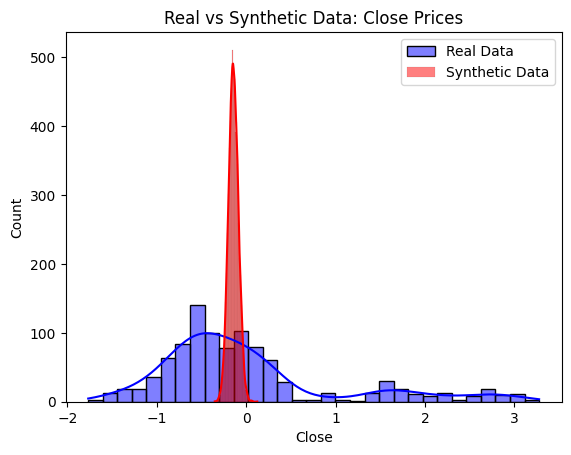

In [ ]:
noise = np.random.normal(0, 1, (10000, 100))
synthetic_data = generator.predict(noise)

real_data_df = pd.DataFrame(X_train, columns=['Open', 'High', 'Low', 'Close', 'Volume', 'Volatility', 'Moving_Avg'])
synthetic_data_df = pd.DataFrame(synthetic_data, columns=['Open', 'High', 'Low', 'Close', 'Volume', 'Volatility', 'Moving_Avg'])

sns.histplot(real_data_df['Close'], kde=True, color='blue', label='Real Data')
sns.histplot(synthetic_data_df['Close'], kde=True, color='red', label='Synthetic Data')
plt.legend()
plt.title("Real vs Synthetic Data: Close Prices")
plt.show()